In [7]:
# finalize model and make a prediction for monthly births with random forest
from numpy import asarray
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import concat
from sklearn.ensemble import RandomForestRegressor
import joblib

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

from statsmodels.tsa import stattools
import statsmodels.api as sm

from statsmodels.tsa.seasonal import seasonal_decompose

In [3]:
data_path = "/content/drive/MyDrive/Colab Notebooks/Hitachi/Data/final_data.csv"
# data_path = "final_data.csv"
data_df = pd.read_csv(data_path)
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27552 entries, 0 to 27551
Data columns (total 28 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Unnamed: 0                      27552 non-null  int64  
 1   datetime                        27552 non-null  object 
 2   Demand (MW)                     27552 non-null  float64
 3   Temperature                     27552 non-null  float64
 4   dewpoint                        27552 non-null  float64
 5   humidity                        27552 non-null  float64
 6   precipitation                   27552 non-null  float64
 7   precipprob                      27552 non-null  float64
 8   snow                            27552 non-null  float64
 9   snowdepth                       27552 non-null  float64
 10  windgust                        27552 non-null  float64
 11  windspeed                       27552 non-null  float64
 12  sealevelpressure                

In [4]:
def min_max_normalize_dataframe(df, columns):
    df_normalized = df.copy()
    for column in columns:
        if df[column].dtype in [int, float]:
            min_val = df[column].min()
            max_val = df[column].max()
            df_normalized[column] = (df[column] - min_val) / (max_val - min_val)
    return df_normalized

data_df.drop(columns=["Unnamed: 0", "datetime"], inplace=True)
features_columns = list(data_df.columns)
features_columns.remove('Demand (MW)')# removing the Demand (MW)

normalized_df = min_max_normalize_dataframe(data_df, columns = features_columns)
transformed_df = normalized_df[features_columns].apply(np.log1p)

transformed_df["Demand (MW)"] = data_df["Demand (MW)"]
transformed_df.head()

,Temperature,dewpoint,humidity,precipitation,precipprob,snow,snowdepth,windgust,windspeed,sealevelpressure,...,rain,snow.1,Clear,Freezing Drizzle/Freezing Rain,Ice,Overcast,Partially cloudy,Rain,Snow,Demand (MW)
0,0.349596,0.383234,0.491779,0.0,0.0,0.0,0.0,0.23543,0.116613,0.387838,...,0.0,0.0,0.000000,0.0,0.0,0.693147,0.000000,0.0,0.0,445.8
1,0.349596,0.389739,0.510850,0.0,0.0,0.0,0.0,0.23543,0.116613,0.386469,...,0.0,0.0,0.000000,0.0,0.0,0.693147,0.000000,0.0,0.0,424.5
2,0.349596,0.396202,0.530131,0.0,0.0,0.0,0.0,0.23543,0.085695,0.387838,...,0.0,0.0,0.000000,0.0,0.0,0.693147,0.000000,0.0,0.0,423.5
3,0.343529,0.389739,0.529492,0.0,0.0,0.0,0.0,0.23543,0.116613,0.386469,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.693147,0.0,0.0,418.8
4,0.329914,0.383234,0.553636,0.0,0.0,0.0,0.0,0.23543,0.085695,0.385098,...,0.0,0.0,0.693147,0.0,0.0,0.000000,0.000000,0.0,0.0,414.8


# Sesonal Decomposition

In [5]:
def check_data_stationarity(X):
  """
    Check if the given series is stationarity time series data or not

    Args:
      X : Time-series data
  """
  # ADF test
  p_threshold = 0.05
  p_val = stattools.adfuller(X)[1]

  if p_val < p_threshold:
    print("Given series is stationarity data")
  else:
    print("Given series is not a stationarity data")

In [6]:
demand_data_series = transformed_df["Demand (MW)"]
check_data_stationarity(demand_data_series)

Given series is stationarity data


<Figure size 640x480 with 0 Axes>

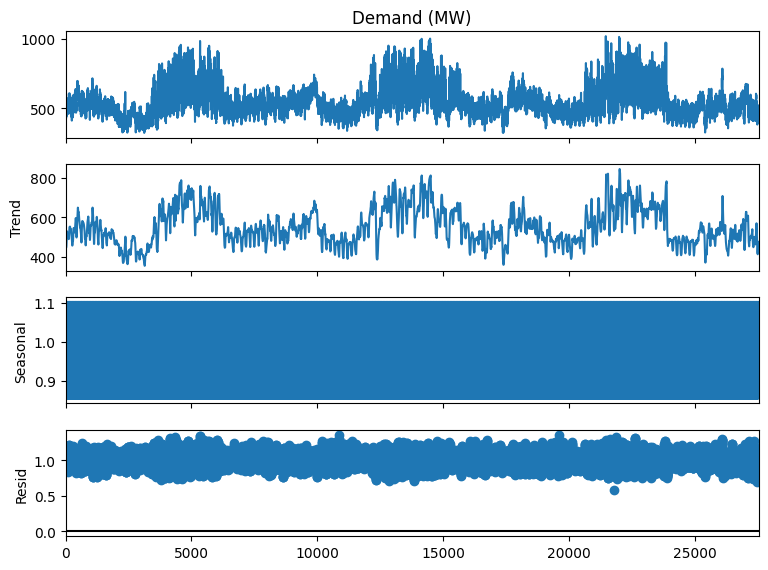

In [66]:
result = seasonal_decompose(demand_data_series, model='multiplicative', period=24, two_sided=False)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(8, 6)
fig.show()

In [67]:
decomposed_result = seasonal_decompose(demand_data_series, model='multiplicative', period=24)
trend_series, seasonal_series, resid_series = decomposed_result.trend, decomposed_result.seasonal, decomposed_result.resid

In [68]:
trend_series.isnull().sum()

24

In [69]:
seasonal_decomposed_df = pd.DataFrame({'trend' : trend_series, 'seasonal' : seasonal_series, 'resid' : resid_series})
seasonal_decomposed_df.head()

,trend,seasonal,resid
0,NaN,0.898095,NaN
1,NaN,0.875872,NaN
2,NaN,0.861163,NaN
3,NaN,0.855097,NaN
4,NaN,0.858431,NaN


In [70]:
seasonal_decomposed_df.tail(13)

,trend,seasonal,resid
27539,474.785417,1.059439,0.968775
27540,NaN,1.073052,NaN
27541,NaN,1.082499,NaN
27542,NaN,1.087411,NaN
27543,NaN,1.089776,NaN
27544,NaN,1.092342,NaN
27545,NaN,1.097449,NaN
27546,NaN,1.102272,NaN
27547,NaN,1.092962,NaN
27548,NaN,1.075892,NaN


In [52]:
seasonal_decomposed_df = seasonal_decomposed_df.dropna()
seasonal_decomposed_df = seasonal_decomposed_df.reset_index(drop=True)

In [54]:
seasonal_decomposed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27528 entries, 0 to 27527
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   trend     27528 non-null  float64
 1   seasonal  27528 non-null  float64
 2   resid     27528 non-null  float64
dtypes: float64(3)
memory usage: 645.3 KB


In [53]:
seasonal_decomposed_df.head()

,trend,seasonal,resid
0,447.727083,1.073052,0.918752
1,447.933333,1.082499,0.893816
2,448.435417,1.087411,0.892063
3,449.006250,1.089776,0.866924
4,449.777083,1.092342,0.880910


# Random Forest Regressor

In [ ]:
# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = concat(cols, axis=1)
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg.values